## 양방향 LSTM과 바다나우 어텐션 매커니즘으로 IMDB 리뷰감성 분류하기

### 1. IMDB 리뷰 데이터 전처리하기
* IMDB 리뷰 데이터
  * 영화 리뷰 데이터
  * 이미 훈련 데이터와 테스트 데이터를 50:50 비율로 구분해서 제공
  * x 데이터
    * 텍스트 전처리 되어 있음 (토큰화, 정수 인코딩)
    * 등장 빈도에 따라 인덱스 부여
  * y 데이터
    * 긍정(1), 부정(0)


In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size=10000 #단어 집합의 크기
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
#num_words는 해당 데이터에서 등장 빈도 순위로 몇 등까지의 단어를 사용할 것인지를 의미

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
print(len(X_train))
print(len(X_test))

25000
25000


In [5]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [6]:
max_len = 500 #평균 길이보다 조금 더 크게 데이터 패딩할거에요오
#근데 여기 질문!! 최대 길이가 2094인 리뷰는 500으로 패딩하면 어떻게 되지...?
#리뷰의 앞쪽 일부가 잘리고 마지막 500개의 토큰만 남게됨.
#pad_sequences 함수는 기본적으로 시퀀스의 뒤쪽이 아닌 앞쪽에서 잘라내는 기능을 함 -> 앞에 잘림!
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 2. 바다나우 어텐션(Bahdanau Attention)
* 어텐션 스코어
  * 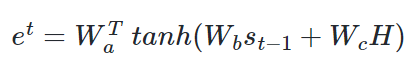


In [7]:
import tensorflow as tf

In [8]:
#BahdanauAttention 클래스의 인스턴스를 생성하고 호출할 때, call 메서드가 자동으로 실행된다
#왜? Tensorflow의 tf.keras.Model 클래스를 상속받아서

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1) #V는 W의 a의 T를 말함. 입력 벡터를 1차원으로 변환하는 완전 연결층을 만든다는 것을 의미

  def call(self, values, query): #key와 value는 같음 -> 인코더의 은닉상태 벡터들 hs
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해주자
    hidden_with_time_axis = tf.expand_dims(query, 1) #차원 1개 추가

    # score shape == (batch_size, max_length, 1)
    # 마지막 축에 1이 있는 이유 -> self.v를 score에 적용하기 때문
    # self.v를 적용하기 전의 텐서 형태 -> (batch_size, max_lenth, units) 이다.
    # units은 모델의 특정 레이어에서 사용되는 뉴런의 수 또는 차원의 크기를 의미 (각 시퀀스의 각 단어에 대해 units 크기의 벡터를 가진 텐서임을 의미)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))) #value는 key랑 같다. key가 들어가야하는데 같으므로 value 사용
    # 여기서 이 코드가 알아서 t-1 시점의 디코더 셀의 숨겨진 상태를 사용해서 연산을 진행함

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1) #가중치를 구하기 위해서 점수를 softmax함

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1) #각 시점별로 가중치 부여한 벡터들을 합산해서 최종 컨텍스트 벡터 생성
    #reduce_sum은 텐서의 모든 성분의 총합을 계산하는 함수이다.

    return context_vector, attention_weights



## 3. 양방향 LSTM + 바다나우 어텐션

In [9]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

#### Encoder & Decoder
* 인코더와 디코더를 명확하게 나누지 않고 하나의 코드 블록에서 정의하고 있음
  * 인코더는 입력 시퀀스를 받아 상태 벡터로 변환
  * 디코더는 이 상태 벡터를 초기 상태로 사용하여 출력 시퀀스를 생성
  * attention mechanism은 디코더가 더 나은 예측을 할 수 있도록 인코더의 모든 출력을 참고


In [11]:
#입력층과 임베딩층 설계
#max_len개의 단어들을 128차원의 벡터로 임베딩하도록 설계

sequence_input= Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [12]:
#양방향 lstm 설계(2층으로)

lstm=Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(embedded_sequences) #두번째 층을 쌓을거니깐 return_sequences를 True로 해줘야함
lstm, forward_h, forward_c, backward_h, backward_c=Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

# Bidirectional : 양방향 RNN
# 64 : LSTM 유닛의 수 (LSTM 셀은 64차원의 출력 벡터를 생성)
# return_sequences = True : True면 LSTM 레이어는 시퀀스의 각 시점에 대한 출력을 반환함. False이면 마지막 시점의 출력만 반환
# return_state=True : True이면 LSTM 레이어는 마지막 타입스텝의 숨겨진 상태와 셀 상태를 반환
# forward_h, forward_c, backward_h, backward_c : 정방향/역방향 LSTM의 마지막 타임스텝의 숨겨진 상태(은닉상태), 셀상태(기억셀)

In [13]:
# 각상태의 크기 SHAPE 출력

print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [14]:
# 정방향, 역방향 상태들을 연결 -> 은닉상태는 인코더의 hs 의미

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [15]:
# 은닉상태를 사용해서 컨텍스트 벡터를 얻어보자 -> 디코더의 t-1시점의 은닉상태벡터와 인코더의 은닉상태벡터들을 사용해서

attention=BahdanauAttention(64) #가중치 크기 정의
context_vector, attention_weights=attention(lstm, state_h) # call 메서드 호출됨.

In [17]:
# 컨텍스트 벡터를 밀집층에 통과 (Affine 계층)
# 이진분류이므로 최종 출력층에 1개의 뉴런을 배치하고, 활성화 함수로 시그모이드 함수 사용

dense1=Dense(20, activation="relu")(context_vector)
dropout=Dropout(0.5)(dense1)
output=Dense(1, activation="sigmoid")(dropout)
model=Model(inputs=sequence_input, outputs=output)

In [21]:
#모델 컴파일

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
#검증데이터로 테스트 데이터를 사용해서 에폭이 끝날때마다 테스트 데이터에 대한 정확도 출력
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
98/98 [==============================] - 1177s 12s/step - loss: 0.4663 - accuracy: 0.7664 - val_loss: 0.2859 - val_accuracy: 0.8817
Epoch 2/3
98/98 [==============================] - 1154s 12s/step - loss: 0.2417 - accuracy: 0.9132 - val_loss: 0.2901 - val_accuracy: 0.8834
Epoch 3/3
98/98 [==============================] - 1149s 12s/step - loss: 0.1797 - accuracy: 0.9384 - val_loss: 0.3324 - val_accuracy: 0.8752


In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

#대략 87%의 정확도를 얻었다.

782/782 [==============================] - 315s 403ms/step - loss: 0.3324 - accuracy: 0.8752

 테스트 정확도: 0.8752


## 정리
* 양방향lstm + 바다나우어텐션 사용해서 리뷰에 대한 감성분석을 수행했다. (긍정은 1, 부정은 0 -> 이진분류)
  * 양방향 lstm
    * 임베딩 텍스트 벡터를 lstm에 forward, backward를 양방향으로 수행해 앞뒤의 단어위치정보가 저장된 은닉상태벡터들을 추출
  * 바다나우 attention
    * 이와 디코더의 각 시점-1의 은닉상태벡터를 사용해 context vector 추출
  * 디코더
    * context vector와 디코더의 은닉상태벡터를 사용해 affine 계층으로 보내고 이진분류이므로 활성화함수로는 sigmoid를 사용해 출력
    * 모델 컴파일 -> 이진분류이므로 binarycrossentropy 사용하고 optimizer로는 adam 사용, 평가지표로는 정확도 사용

